In [1]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d

In [2]:
with open('0021500495.json', 'r') as json_file:
    event_data = json.load(json_file)

In [5]:
def make_position_dataframe(event_data, target_team_id, target_player_id, target_event_id=None):
    
    event_df = pd.DataFrame()
    
    for event in event_data['events']:
        event_id = event['eventId']

        if target_event_id is not None and event_id != str(target_event_id):
            continue
        
        moment_df = pd.DataFrame()
        
        for moment in event['moments']:
            timestamp = moment[1]
            qtr = moment[0]
            qtr_rem = moment[2]
            shot_rem = moment[3]
            
            for player_pos_data in moment[5]:
                team_id = player_pos_data[0]
                player_id = player_pos_data[1]
                
                
                #if team_id ==target_team_id:
                    #import pdb; pdb.set_trace()
                
                if team_id==target_team_id and player_id==target_player_id:
                    
                    x = player_pos_data[2]
                    y = player_pos_data[3]
                    z = player_pos_data[4]
                    
                    row = {'eventId':event_id, 'timestamp':timestamp,
                          'qtr':qtr, 'qtr_rem':qtr_rem, 'shot_rem':shot_rem,
                          'team_id':team_id, 'player_id':player_id,
                          'x':x, 'y':y, 'z':z}
                    
                    moment_df = pd.concat([moment_df, pd.DataFrame([row])])
                    
            
        event_df = pd.concat([event_df, moment_df])
        
    return event_df

In [6]:
ball_data_crowder_ft = make_position_dataframe(event_data, -1, -1, 39)

In [26]:
def rolling_distance(frames):
    import pdb; pdb.set_trace()
    try:
        current_frame = frames['x']
        last_frame = frames['y']
    except KeyError:
        return 0
    
    return (current_frame['x']-last_frame['x'])**2 + \
           (current_frame['y']-last_frame['y'])**2 + \
           (current_frame['z']-last_frame['z'])**2

In [41]:
ball_data_crowder_ft['velocity'] = ball_data_crowder_ft['x'].rolling(2,min_periods=2).apply(lambda x: (x.values[-1]-x.values[-2])**2) + \
ball_data_crowder_ft['y'].rolling(2,min_periods=2).apply(lambda x: (x.values[-1]-x.values[-2])**2) + \
ball_data_crowder_ft['z'].rolling(2,min_periods=2).apply(lambda x: (x.values[-1]-x.values[-2])**2)

(0.0, 1.0)

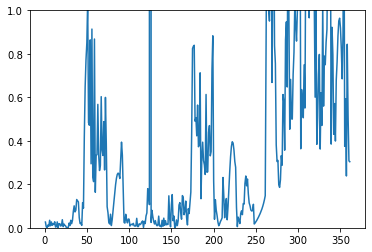

In [46]:
plt.plot(range(len(ball_data_crowder_ft['velocity'])), ball_data_crowder_ft['velocity'])
plt.ylim(0,1)

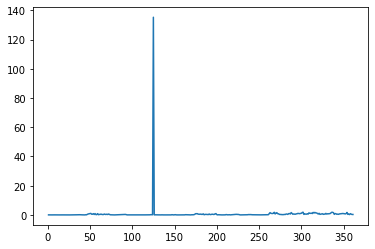

In [47]:
plt.plot(range(len(ball_data_crowder_ft['velocity'])), ball_data_crowder_ft['velocity'])
